In [59]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.linalg import cho_solve, cho_factor
from tqdm import tqdm
import open3d as o3d
from itertools import chain
from pathlib import Path
import json

import sys
np.set_printoptions(precision=4, linewidth=200, sign=" ")
plt.rcParams["figure.figsize"] = [15,10]

## Data loading

In [60]:
file_name = "chris_center_start"
transform_details ="_5_1"
rust_path = Path(r"C:\Users\chris\Documents\Work\Polymetrix\Rust\CruxTest")
# rust_path = Path(r"/Users/chrisvail/Documents/CruxTest")

frame_data_path = rust_path / "preprocessing/examples/output" / file_name
transform_data_path = rust_path / "matcher/examples/output/final_transform" / f"{file_name}{transform_details}.json"

In [61]:
def flatten(x: [[]]):
    return [y for xs in x for y in xs]

In [62]:
# frames = []

# for f in tqdm(sorted(list(frame_data_path.glob("*.json")))):
#     with open(f, "r") as inp:
#         frame_data = json.load(inp)
#         positions, normals = zip(*tuple(map(lambda x: (x["position"], x["normal"]), filter(lambda x: x["valid"], flatten(frame_data["frame"])))))
#         positions, normals = np.array(positions), np.array(normals)

#         frames.append({"positions": positions, "normals": normals})

In [63]:
transforms = []

with open(transform_data_path, "r") as inp:
    data = json.load(inp)
    transforms = [np.array(x).reshape((4,4)).T for x in data]

## Visualisation

In [64]:
def create_axis(transform, colour, size=0.2):
    mesh = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size, origin=np.array([0.0,0.0,0.0]))
    mesh.paint_uniform_color(colour)
    mesh.transform(transform)
    return mesh

In [65]:
stride = 10
poses = [create_axis(x, [0.7,0.2,0.2] if i % stride else [0.9,0,0], 0.01 if i % stride else 0.025) for i, x in enumerate(transforms)]


o3d.visualization.draw_geometries([x for x in chain(poses, [create_axis(np.eye(4), [0,0,0], 0.05)])])

## Selecting Loop Closures

In [66]:
def np_cross(x):
    return np.array([
        [0,-x[2],x[1]],
        [x[2],0,-x[0]],
        [-x[1],x[0],0]
    ])

def np_exp(x):
    theta = np.linalg.norm(x[3:])
    if theta == 0:
        R = np.eye(3)
        t = x[:3]
    else:
        a = np.sin(theta)/theta
        b = (1 - np.cos(theta))/(theta*theta)
        c = (theta - np.sin(theta))/(theta**3)
        w = np_cross(x[3:])
        R = np.eye(3) + a*w + b*w@w

        t = (np.eye(3) + b*w + c*w@w)@x[:3]
    
    mat = np.eye(4)
    mat[:3, :3] = R
    mat[:3, 3] = t

    return mat

def np_log(T):
    theta = np.arccos(np.clip((np.trace(T) - 2) / 2, -1, 1))
    # theta = np.arccos((T[0, 0] + T[1, 1] + T[2, 2] - 1) / 2)


    if theta == 0:
        return np.array([T[0, 3], T[1, 3], T[2, 3], 0, 0, 0
])
    a = np.sin(theta)/theta
    b = (1 - np.cos(theta))/(theta*theta)

    x4 = 1/(2*a)*(T[2, 1] - T[1, 2])
    x5 = 1/(2*a)*(T[0, 2] - T[2, 0])
    x6 = 1/(2*a)*(T[1, 0] - T[0, 1])
    
    w = np_cross(np.array([x4,x5,x6]))
    u = (np.eye(3) - 1/2*w + 1/(theta**2)*(1 - a/(2*b))*w@w)@T[:3, 3]

    return np.array([u[0], u[1], u[2], x4, x5, x6])

In [67]:
from scipy.spatial.transform import Rotation

T = np.eye(4)
T[:3,3] = np.array([1,2,3])
T[:3,:3] = Rotation.from_euler("XYZ", [1E-6]*3).as_matrix()
Tp = np.eye(4)
Tp[:3,:3] = Rotation.from_euler("XYZ", [1E-6]*3).as_matrix()

np_log(Tp@Tp@Tp@Tp@Tp@Tp@Tp@Tp@Tp@Tp@T)

array([ 1.0e+00,  2.0e+00,  3.0e+00,  1.1e-05,  1.1e-05,  1.1e-05])

In [68]:
def interpolate_matrix(transform_1, transform_2, factor):
    return np_exp(np_log(transform_2@np.linalg.inv(transform_1))*factor)@transform_1

(0.02157900463446806, 59)
(0.017532916161234452, 55)
(0.011574203846023279, 49)
(0.021830024590823463, 46)
(0.06985863049384924, 28)
(0.012492032237300462, 18)
(0.023016661533977734, 0)
(0.016876244269897003, 85)
(0.09313120697926805, 68)
(0.02871887713714187, 64)


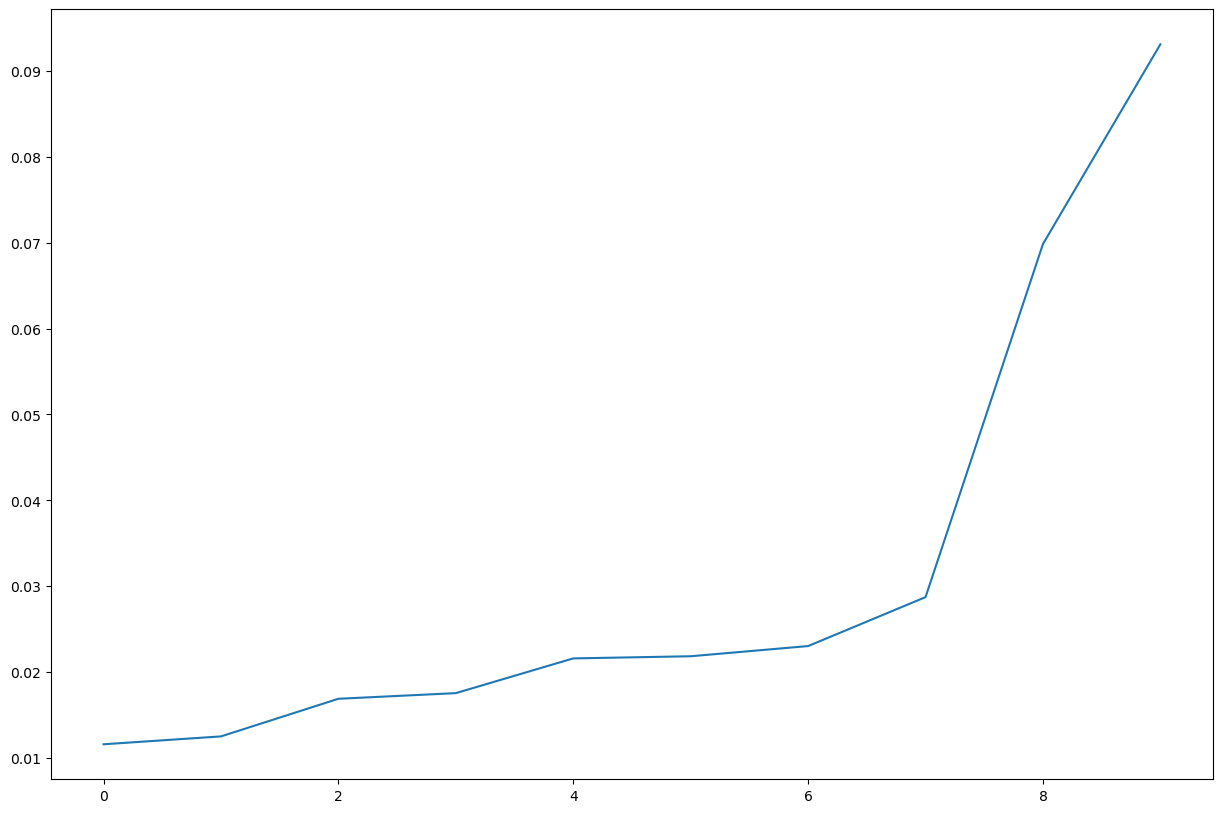

In [69]:
threshold_distance = 12
best_matches = []

for i in range(0, len(transforms), stride):
    a = transforms[i][:3, 3]
    best_match = (500, -1)
    for j in range(0, len(transforms)):
        if abs(i - j) < threshold_distance:
            continue
        b = transforms[j][:3, 3]
        best_match = min(best_match, (np.linalg.norm(a - b), j))
    best_matches.append(best_match)
    print(best_match)

plt.plot(sorted([x for x, _ in best_matches]))

In [70]:
def visualise_closures(transforms, matches, stride=10):
    poses = [create_axis(x, [0.7,0.2,0.2] if i % stride else [0.9,0,0], 0.01 if i % stride else 0.025) for i, x in enumerate(transforms)]

    matches = [create_axis(transforms[x], [0.2,0.7,0.2], 0.025) for x in matches]

    o3d.visualization.draw_geometries([x for x in chain(poses, matches, [create_axis(np.eye(4), [0,0,0], 0.05)])])

    
visualise_closures(transforms, map(lambda x: x[1], filter(lambda x: x[0] < 0.035, best_matches)), 10)

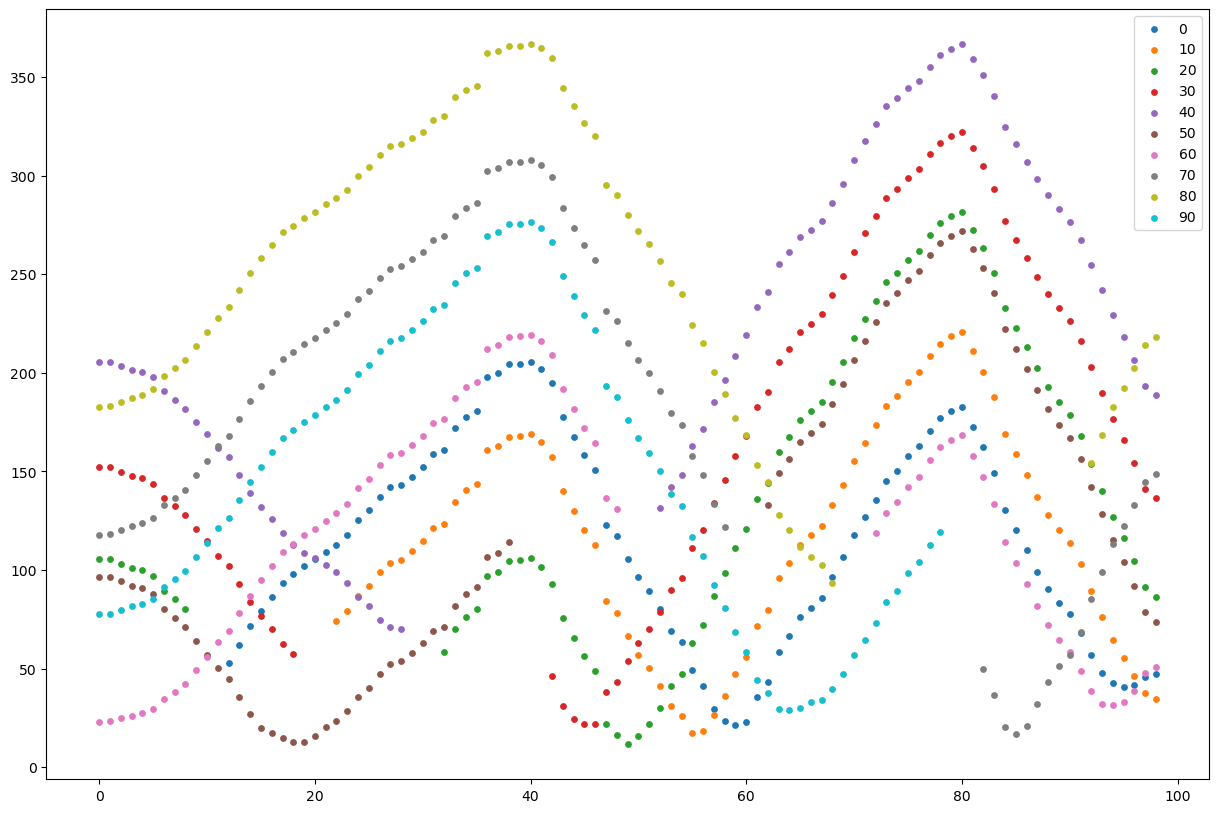

In [71]:
threshold_distance = 12
stride = 10

for i in range(0, len(transforms), stride):
    a = transforms[i]
    xs = []
    ys = []
    for j in range(0, len(transforms)):
        if abs(i - j) < threshold_distance:
            continue
        b = transforms[j]

        xs.append(j)
        # ys.append(np.arccos(np.clip(np.dot(a[:3, 2], b[:3, 2]), -1, 1)))
        ys.append(np.linalg.norm(a[:3,3] - b[:3,3])*1000)

        if ys[-1] < 0.1:
            print(f"{i}\t {j}\t {ys[-1]:.4f}      {np.linalg.norm(a[:3,3] - b[:3,3])*1000:.2f}")

    print()
    plt.scatter(xs, ys, s=15, label=f"{i}")

plt.legend()
# plt.ylim((0,50))


In [72]:
threshold_distance = 12
stride = 10
best_matches = []

for i in range(0, len(transforms), stride):
    a = transforms[i]
    best_match = [(128, 5000)]
    for j in range(0, len(transforms)):
        if abs(i - j) < threshold_distance:
            continue
        b = transforms[j]

        if np.linalg.norm(a[:3,3] - b[:3,3]) < 0.05 and np.arccos(np.clip(np.dot(a[:3, 2], b[:3, 2]), -1, 1)) < 0.1:
            score = np.linalg.norm(a[:3,3] - b[:3,3]) * np.arccos(np.clip(np.dot(a[:3, 2], b[:3, 2]), -1, 1))

            if j - best_match[-1][1] > threshold_distance:
                best_match.append((score, j))
            elif best_match[-1][0] > score:
                best_match[-1] = (score, j)

    if best_match[0] == (128,5000):
        best_matches.append([])
    else:
        best_matches.append(best_match)

for m in best_matches:
    print(m)

[(0.004279486458305791, 94)]
[(0.0013811734181157845, 55), (0.0032221622697074575, 98)]
[(0.0009540216783240921, 49)]
[(0.0017712480174564107, 46)]
[]
[(0.0009376759221074954, 18)]
[(0.0006059564476717955, 92)]
[(0.00027441456595924405, 84)]
[]
[(0.0010125071658639946, 63)]


In [73]:
def get_candidates(transforms, stride=10, temporal_distance=12, angle=0.1, distance=0.05):
    best_matches = []

    for i in range(0, len(transforms), stride):
        a = transforms[i]
        best_match = [(128, 5000)]
        for j in range(0, len(transforms)):
            if abs(i - j) < threshold_distance:
                continue
            b = transforms[j]

            if np.linalg.norm(a[:3,3] - b[:3,3]) < 0.035 and np.arccos(np.clip(np.dot(a[:3, 2], b[:3, 2]), -1, 1)) < 0.1:
                score = np.linalg.norm(a[:3,3] - b[:3,3]) #* np.arccos(np.clip(np.dot(a[:3, 2], b[:3, 2]), -1, 1))

                if j - best_match[-1][1] > threshold_distance:
                    best_match.append((score, j))
                elif best_match[-1][0] > score:
                    best_match[-1] = (score, j)

        if best_match[0] == (128,5000):
            continue
        else:
            for score, j in best_match:
                best_matches.append((i, j, score))
    
    return best_matches

candidates = get_candidates(transforms)
candidates

[(10, 55, 0.017532916161234452),
 (10, 98, 0.034772611848551925),
 (20, 49, 0.011574203846023279),
 (30, 46, 0.021830024590823463),
 (50, 18, 0.012492032237300462),
 (60, 94, 0.031514795981000134),
 (70, 85, 0.016876244269897003),
 (90, 64, 0.02871887713714187)]

In [74]:
visualise_closures(transforms, map(lambda x: x[1],candidates))

## Pose graph debugging

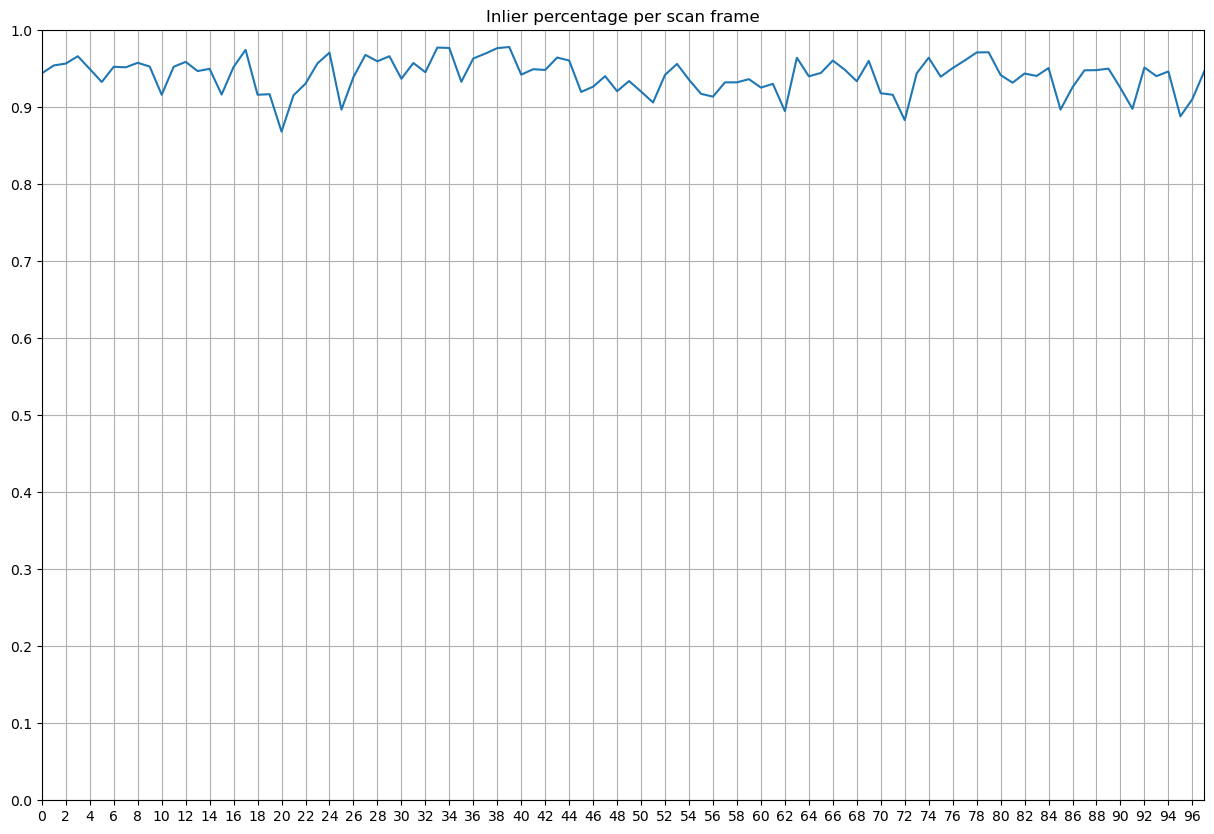

In [75]:
file_name = "chris_center_start"
transform_details ="_5_1"
transform_data_path = rust_path / "pose_graph/examples/output" / f"{file_name}{transform_details}.json"


pg_transforms = []
pg_candidates = []
inliers = None

with open(transform_data_path, "r") as inp:
    data = json.load(inp)
    pg_transforms = [np.array(x).reshape((4,4)).T for x in data["poses"]]
    pg_candidates = data["candidates"]
    inliers = data["inliers"]

fig, ax = plt.subplots(1,1)

ax.plot(inliers)
ax.set_title("Inlier percentage per scan frame")
ax.set_ylim((0,1))
ax.set_xlim((0, len(inliers) - 1))
ax.grid(True, "both")
ax.set_xticks(np.arange(0,len(inliers) - 1, 2))
ax.set_yticks(np.arange(11)*0.1)


In [76]:
visualise_closures(pg_transforms, map(lambda x: x[1], pg_candidates))

## Fixing pose errors

From the above graph, its clear that there are problems with how the matching is occuring. I want to see what happens if we fix the "bad" associations with just a linear extrapolation from the previous poses

In [77]:
current_pose = np.eye(4)
poses = [current_pose]

for i, (prev, curr, in_perc) in enumerate(zip(pg_transforms, pg_transforms[1:], inliers)):
    if in_perc < 0.8 and i > 1:
        # Calculate the new delta
        delta = prev@np.linalg.inv(pg_transforms[i - 1])

    else:
        delta = curr@np.linalg.inv(prev)
    
    current_pose = delta@current_pose
    poses.append(current_pose)


In [78]:
visualise_closures(poses, [])

In [79]:
visualise_closures(poses, map(lambda x: x[1], get_candidates(poses)))

## Pose Graph ICP Failure Options

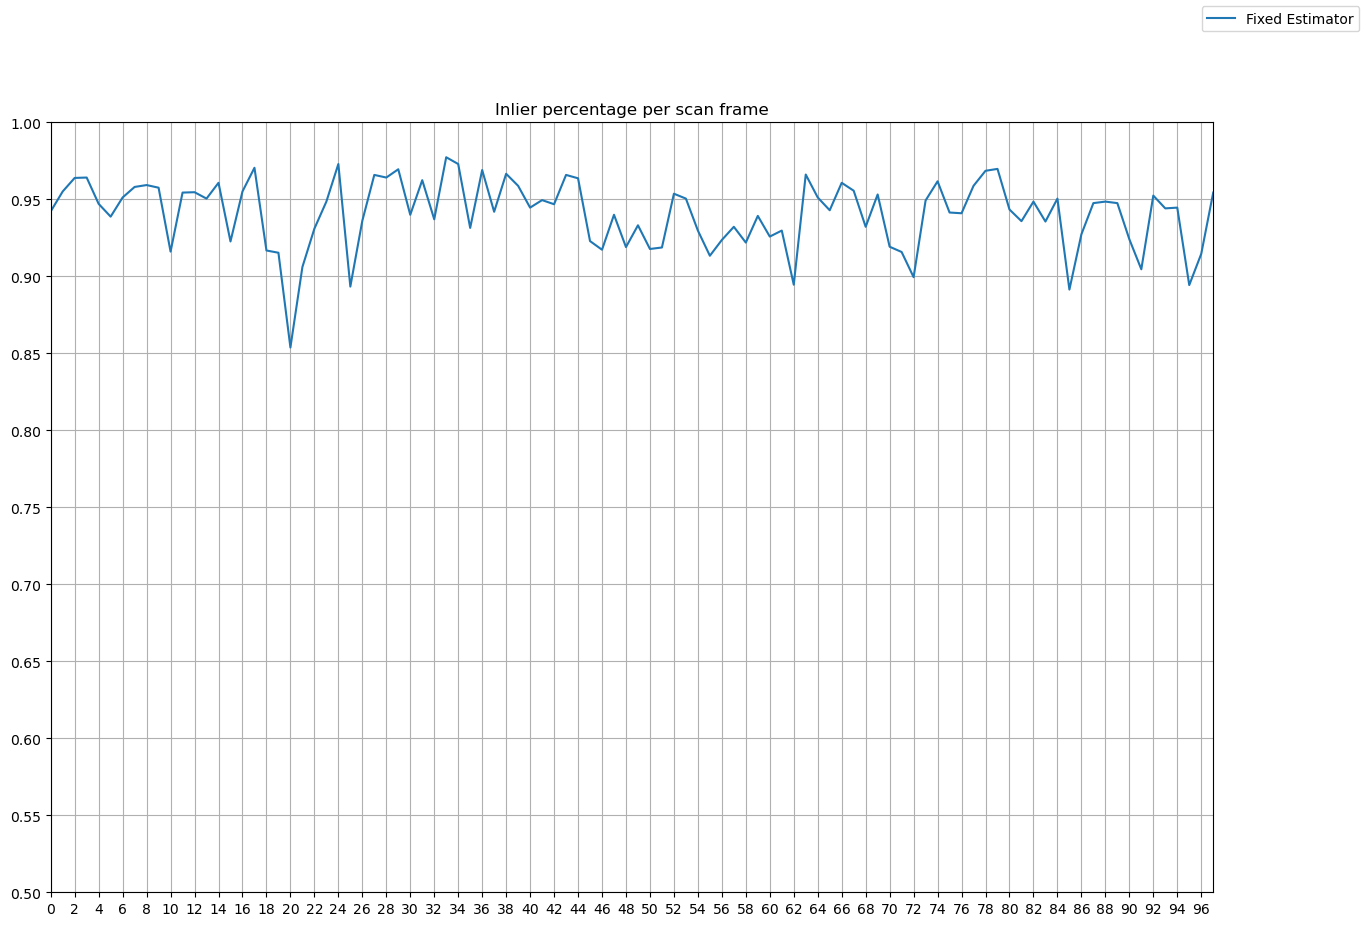

In [80]:
transform_data_path = rust_path / "pose_graph/examples/output"

paths = transform_data_path.glob("*.json")

fig, ax = plt.subplots(1,1)


for p in paths: 
    if "fixed" not in p.stem:
        continue
    pg_transforms = []
    pg_candidates = []
    inliers = None

    with open(p, "r") as inp:
        data = json.load(inp)
        pg_transforms = [np.array(x).reshape((4,4)).T for x in data["poses"]]
        pg_candidates = data["candidates"]
        inliers = data["inliers"]

    ax.plot(inliers, label=p.stem[23:].replace("_", " ").title())

    # visualise_closures(pg_transforms, map(lambda x: x[1], get_candidates(pg_transforms)))


ax.set_title("Inlier percentage per scan frame")
ax.set_ybound((0.5, 1))
ax.set_xbound((0, len(inliers) - 1))
ax.grid(True, "both")
ax.set_xticks(np.arange(0,len(inliers) - 1, 2))
ax.set_yticks(np.arange(11)*0.05+0.5)
fig.legend()
